# Mateusz Skowron lab6

# Zastosowanie wielomianów orgtogonalnych w medycynie obliczeniowej


 Użycie wielomianów ortogonalnych do analizy EKG 

Instalacja wymaganych pakietów

In [2]:
using Pkg
using SpecialPolynomials
using Polynomials
using Plots
using LinearAlgebra
using CSV
using DataFrames
using Statistics

## Teoria

**Wielomiany ortogonalne** to rodzina wielomianów, w których iloczyn skalarny dwóch róznych wielomianów jest równa 0.

Jeżeli dodatkowo iloczyn skalarny wielomianu "przez siebie" jest równy 1, to nazywamy je **wielomianami ortonormalnymi**

Iloczyn skalarny wielomianów można zdefiniować jako:

$<P_m,P_n>=\int_a^b P_n(x)P_m(x)W(x)dx = 0$

Funkcja *W* jest nazywana *funkcją wagową*.

### Przykładowe rodziny wielomianów ortogonalnych

| Nazwa                | Przedział       | Funkcja wagowa           | Zastosowanie                                           | Parzystość                                                     |
|----------------------|-----------------|--------------------------|--------------------------------------------------------|----------------------------------------------------------------|
| Czebyszewa (1 rzędu) | [-1,1]          | $\frac{1}{\sqrt{1-x^2}}$ | Zera wielomianu jako węzły interpolacji wielomianowej  | Dla parzystego k - parzyste, dla nieparzystego k - nieparzyste |
| Legendre             | [-1,1]          | 1                        | Zera wielomianu jako węzły kwadratur Gaussa-Legendre'a | jw                                                             |
| Hermite              | [$-\infty$,$\infty$] | $\exp(-x^2)$             | Zera wielomianu jako węzły kwadratur Gaussa-Hermite'a  | jw                                                             |
| Laguerre             | [0,$\infty$]      | $\exp(-x)$               | Zera wielomianu jako węzły kwadratur Gaussa-Laguerra'a | brak                                                           |


### Wielomiany Hermite'a

Zdefiniowane są rekurencyjnie jako:

$H_0(x) = 1$

$H_1(x) = 2x$

$H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}$

Wykres przykładowego wielomianu (tutaj 3 stopnia)

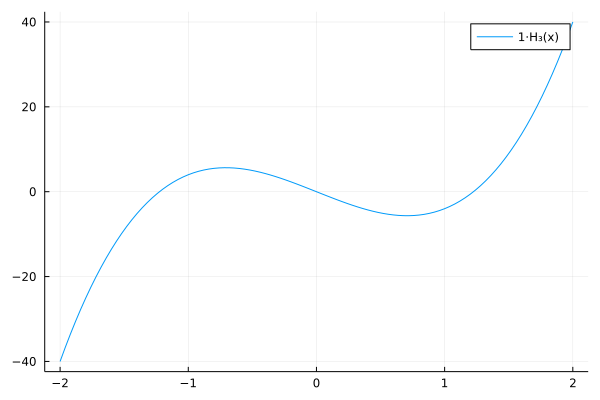

In [3]:
h3 = Hermite([0, 0, 0, 1])
plot(h3, -2, 2)

Żeby nie podawać wektora ze współczynnikami kolejnych stopni, można zrobić inaczej

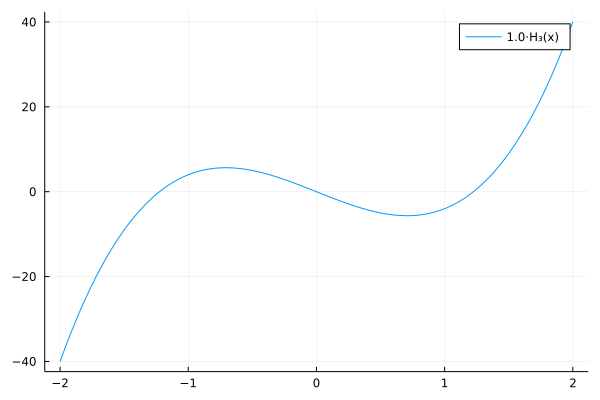

In [4]:
h4 = basis(Hermite, 3)
plot(h4, -2, 2)

### Przykład aproksymacji

Spróbujemy dokonać aproksymacji zaszumionej funkcji `cos` wykorzystując rodzinę wielomianów ortogonalnych Hermite'a.

In [5]:
# Definicja węzłów
xx = -5:.1:5
yy = cos.(xx/3 .+.2).^2 .+ rand(length(xx))/5;

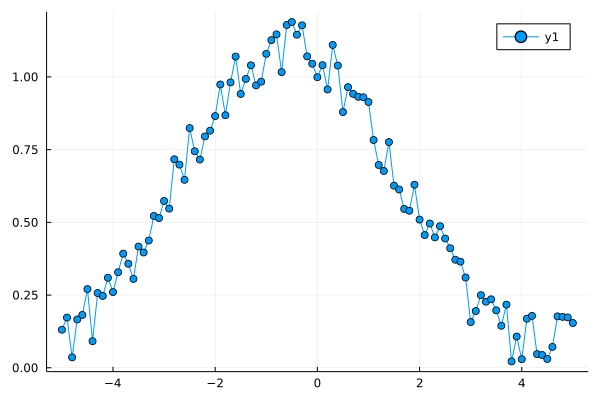

In [6]:
plot(xx, yy, markershape=:circle)

Obliczony wektor wartości normalizujemy do 1, żeby łatwiej policzyć współczynniki aproksymacji (niżej objaśnienie dlaczego łatwiej). 

In [7]:
#przykład prostego wektora, który znormalizujemy
vec=[2,2,2,2]

4-element Vector{Int64}:
 2
 2
 2
 2

In [8]:
# iloczyn skalarny = długość^2
dot(vec,vec)

16

In [9]:
# normalizacja - długość wektora =1
normalize(vec)

4-element Vector{Float64}:
 0.5
 0.5
 0.5
 0.5

In [10]:
# sprawdzamy długość^2
dot(normalize(vec), normalize(vec))

1.0

* 0bliczamy funkcję bazową uwzględniającą czynnik wagowy.
$<P_m,P_n>=\int_{-\infty}^{\infty} H_n(x)H_m(x)\exp(-x^2)dx 
= \int_{-\infty}^{\infty}\underbrace{H_n(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_n}\underbrace{H_m(x)\exp(-\frac{x^2}{2})}_{\text{funkcja bazowa}_m}$

* Wyliczamy jej wartości dla podanych punktów x
* Otrzymany wektor wartości normalizujemy


In [11]:
# obliczamy funkcję bazową
# argument 'norm'  na potrzeby wykresów
function base_fun(k, x, norm=true)
    H_k = basis(Hermite, k).(x)
    app = H_k .* exp.(-(x.^2)/2)
    # normalize to have norm 1
    if norm
        return normalize(app)
    end
    return app
end

base_fun (generic function with 2 methods)

In [12]:
y_2_unnorm = base_fun(2, xx, false);
y_2_norm = base_fun(2, xx, true);

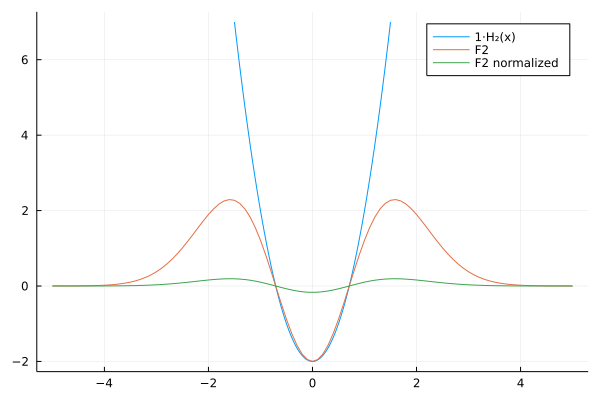

In [13]:
plot(Hermite([0, 0, 1]), -1.5, 1.5)
plot!(xx, y_2_unnorm, label="F2")
plot!(xx, y_2_norm, label="F2 normalized")

Obliczamy wektory wartosci dla punktów w xx dla kilku kolejnych funkcji bazowych

In [14]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);

Sprawdźmy czy baza jest ortonormalna (uwaga: zamiast liczyć całkę, sprawdzamy po prostu iloczyn skalarny wektorów wartości)

In [15]:
dot_base = Array{Float64, 2}(undef, 4, 4); 

for (i, f_i) in enumerate([f0, f1, f2, f3]) 
    for (j, f_j) in enumerate([f0, f1, f2, f3])
        dot_base[i,j] = dot(f_i, f_j)
    end
end

In [16]:
dot_base

4×4 Matrix{Float64}:
  1.0           2.13214e-17  -3.25356e-11   1.22645e-17
  2.13214e-17   1.0          -1.94247e-18  -9.61163e-10
 -3.25356e-11  -1.94247e-18   1.0          -2.83388e-19
  1.22645e-17  -9.61163e-10  -2.83388e-19   1.0

OK, baza jest ortonormalna

Obliczamy kolejne współczynniki aproksymacji. Dzięki ortonormalnej bazie, poszczególne współczynniki są iloczynami skalarnymi wektora wartości funkcji aproksymowanej oraz  wektora bazowego (analogia: rzut  wektora wartości funkcji aproksymowanej w kierunku wektora bazowego).

Wektor bazowy jest znormalizowany $|\vec{j}|=1$, co upraszcza obliczenia.

Analogia w 2D

$\text{rzut }\vec{a} \text{ w kierunku }  \vec{j} =|\vec{a}|\cdot cos(\angle(\vec{a},\vec{j}))=|\vec{a}|\cdot|\vec{j}|\cdot cos(\angle(\vec{a},\vec{j}))=dot(\vec{a},\vec{j})$

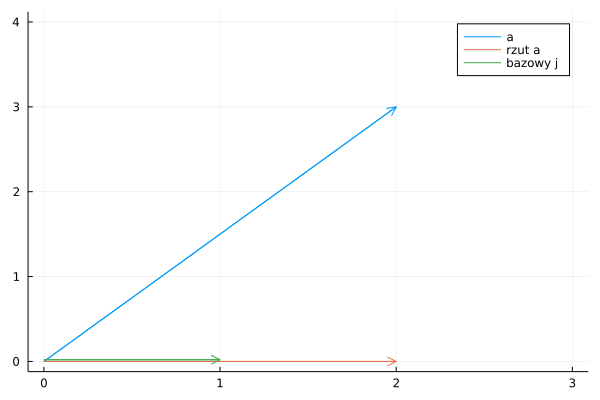

In [17]:
plot([0,2],[0,3],xrange=[0,3], yrange=[0,4],arrow=true, label="a")
plot!([0,2],[0,0],xrange=[0,3], yrange=[0,4],arrow=true, label="rzut a")
plot!([0,1],[0.02,0.02],xrange=[0,3], yrange=[0,4],arrow=true, label="bazowy j")

In [18]:
c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c0, c1, c2, c3

(5.779577608898674, -0.8501960415507044, 2.62507482816929, -0.6353224292105774)

Liczymy wartości aproksymowane kolejnymi stopniami

In [19]:
y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;

In [20]:
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;

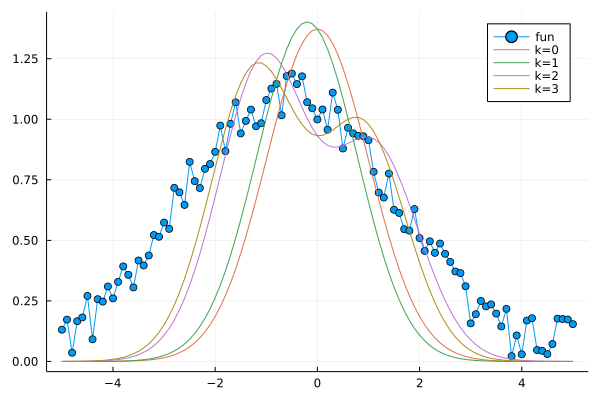

In [21]:
plot(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")

Liczymy błędy aproksymacji kolejnymi stopniami

In [22]:
mse(y1, y2) = mean((y1-y2).^2)

mse (generic function with 1 method)

In [23]:
mse(yy, y_app_0)

0.12330640796872558

In [24]:
mse(yy, y_app_01)

0.11614964253240391

In [25]:
mse(yy, y_app_012)

0.04792174298314374

In [26]:
mse(yy, y_app_0123)

0.04392536090298165

### EKG

Dane pochodzą z bazy https://www.physionet.org/content/mitdb/1.0.0/ .

W sygnale można wyróżnić wiele struktur, z których najbardziej charakterystyczną jest zespół QRS.

In [27]:
ekg_data = CSV.read("ecg_data.csv", DataFrame);

In [28]:
first(ekg_data, 5)

,time,signalN,signalV
,Float64,Float64,Float64
1,-0.1,0.0183886,-0.0990972
2,-0.0972222,0.0145191,-0.0920442
3,-0.0944444,0.012849,-0.0831644
4,-0.0916667,0.0124946,-0.0722728
5,-0.0888889,0.0124117,-0.0593656


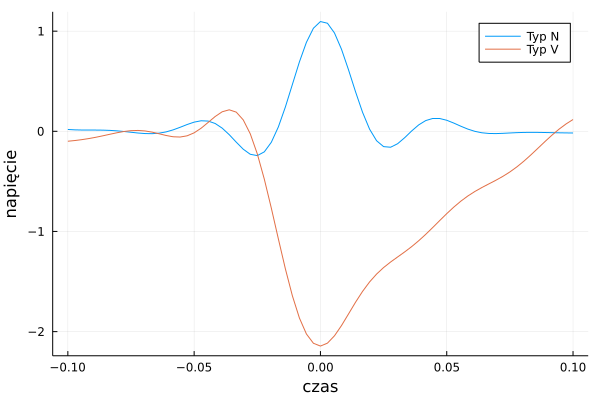

In [29]:
plot(ekg_data.time, ekg_data.signalN, label="Typ N", xlabel = "czas", ylabel="napięcie")
plot!(ekg_data.time, ekg_data.signalV, label="Typ V")

(5.725113911598116, -0.9157906158817669, 2.711325477169205, -0.8018390195854078)

Uwaga: Funkcje bazowe mają pewną "szerokość" i najlepiej aproksymują inne funkcje o podobnej szerokości. Można dodatkowo sparametryzować f. bazowe aby były węższe i lepiej pasowały do zespołów QRS. Na potrzeby laboratorium postąpimy inaczej - przeskalujemy oś X aproksymowanych sygnałów.

## Zadania

In [30]:
xx_ekg  = ekg_data.time*40
yy_ekgV = ekg_data.signalV;
yy_ekgN = ekg_data.signalN;

#### Zadanie 1 (1 pkt)

Narysować 6 pierwszych wielomianów Hermita (na jednym wykresie albo siatce 2x3 lub 3x2)

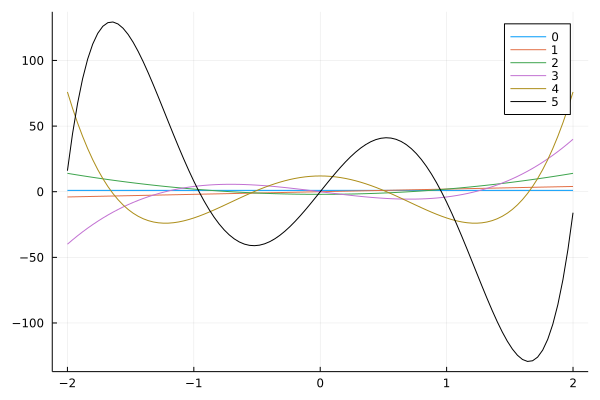

In [31]:
h0 = basis(Hermite, 0)
h1 = basis(Hermite, 1)
h2 = basis(Hermite, 2)
h3 = basis(Hermite, 3)
h4 = basis(Hermite, 4)
h5 = basis(Hermite, 5)
plot(h0, -2, 2, label="0")
plot!(h1, -2, 2, label="1")
plot!(h2, -2, 2, label="2")
plot!(h3, -2, 2, label="3")
plot!(h4, -2, 2, label="4")
plot!(h5, -2, 2, label="5", color = "black")

#### Zadanie 2  (1 pkt)

Narysować 6 pierwszych funkcji aproksymujących

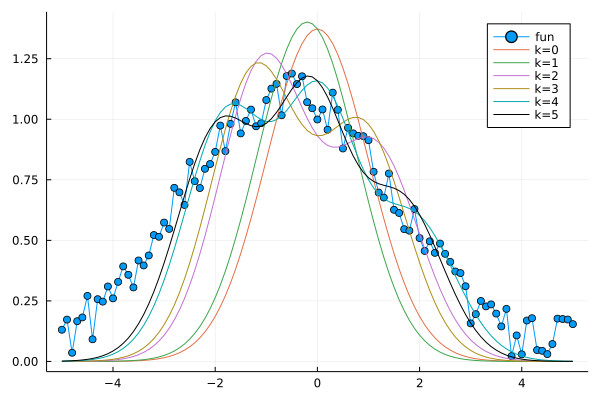

In [32]:
f0 = base_fun(0, xx, true);
f1 = base_fun(1, xx, true);
f2 = base_fun(2, xx, true);
f3 = base_fun(3, xx, true);
f4 = base_fun(4, xx, true);
f5 = base_fun(5, xx, true);

c0 = dot(yy, f0)
c1 = dot(yy, f1)
c2 = dot(yy, f2)
c3 = dot(yy, f3)
c4 = dot(yy, f4)
c5 = dot(yy, f5)
c0, c1, c2, c3, c4, c5

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;
y_app_5 = c5*f5;

y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_012 + y_app_3 + y_app_4;
y_app_012345 = y_app_012 + y_app_3 + y_app_4 + y_app_5;

plot(xx, yy, markershape=:circle, label="fun")
plot!(xx, y_app_0, label="k=0")
plot!(xx, y_app_01, label="k=1")
plot!(xx, y_app_012, label="k=2")
plot!(xx, y_app_0123, label="k=3")
plot!(xx, y_app_01234, label="k=4")
plot!(xx, y_app_012345, label="k=5", color ="black")

#### Zadanie 3  (1 pkt)

Pokazać, że same wielomiany nie są ortogonalne, ale już z funkcją wagową $exp(-x^2)$ są. Uzyć metody z wektorami wartości, założyć pewien przedział.

In [45]:
xs = -5:.1:5

-5.0:0.1:5.0

#### Same wielomiany

In [46]:
h0 = Hermite([1]).(xs)
h1 = Hermite([0, 1]).(xs)
h2 = Hermite([0, 0, 1]).(xs)
h3 = Hermite([0, 0, 0, 1]).(xs)
h4 = Hermite([0, 0, 0, 0, 1]).(xs)
h5 = Hermite([0, 0, 0, 0, 0, 1]).(xs)

dot_base = Array{Float64, 2}(undef, 6, 6); 

for (i, h_i) in enumerate([h0, h1, h2, h3, h4, h5]) 
    for (j, h_j) in enumerate([h0, h1, h2, h3, h4, h5])
        dot_base[i,j] = dot(h_i, h_j)
    end
end

dot_base

6×6 Matrix{Float64}:
  101.0            -1.06581e-14  3232.0          …   1.70137e5    4.36557e-11
   -1.06581e-14  3434.0             3.41061e-13     -2.91038e-11  1.13091e7
 3232.0             3.41061e-13     1.96801e5        1.2485e7     2.79397e-9
    1.36424e-12     1.89529e5       2.91038e-11     -1.86265e-9   8.52416e8
    1.70137e5      -2.91038e-11     1.2485e7         8.80768e8    1.19209e-7
    4.36557e-11     1.13091e7       2.79397e-9   …   1.19209e-7   6.01582e10

Widać, że wielomiany nie są ortogonalne. Iloczyn wielomianów powinien dać zero dla każdej pary.

#### Wielomiany z funkcją wagową exp(-x^2)

In [79]:
h0 = (Hermite([1]).(xs)).*exp.(-(xs.^2)/2)
h1 = (Hermite([0, 1]).(xs)).*exp.(-(xs.^2)/2)
h2 = (Hermite([0, 0, 1]).(xs)).*exp.(-(xs.^2)/2)
h3 = (Hermite([0, 0, 0, 1]).(xs)).*exp.(-(xs.^2)/2)
h4 = (Hermite([0, 0, 0, 0, 1]).(xs)).*exp.(-(xs.^2)/2)
h5 = (Hermite([0, 0, 0, 0, 0, 1]).(xs)).*exp.(-(xs.^2)/2)

dot_base = Array{Float64, 2}(undef, 6, 6); 

for (i, h_i) in enumerate([h0, h1, h2, h3, h4, h5]) 
    for (j, h_j) in enumerate([h0, h1, h2, h3, h4, h5])
        dot_base[i,j] = dot(h_i, h_j)
    end
end

dot_base

6×6 Matrix{Float64}:
 17.7245       -1.15316e-16  …    -1.57133e-7       2.56051e-14
 -1.15316e-16  35.4491            -9.21163e-15     -1.54106e-5
 -1.63109e-9   -3.72467e-16       -1.64317e-5       3.66029e-15
 -1.9096e-15   -1.6692e-7          2.5675e-14      -0.0015525
 -1.57133e-7   -9.21163e-15     6806.22             2.3016e-13
  2.56051e-14  -1.54106e-5   …     2.3016e-13   68062.1

Widać, że wielomiany są ortogonalne. Iloczyn wielomianów daje zero dla każdej pary
(nie licząc mnożenia wielomianu przez samego siebie).

#### Zadanie 4  (1 pkt)

Dokonać aproksymacji zespołu QRS typu N oraz V za pomocą kilku kolejnych stopni. Przedstawić osobno wykresy dla N i V.

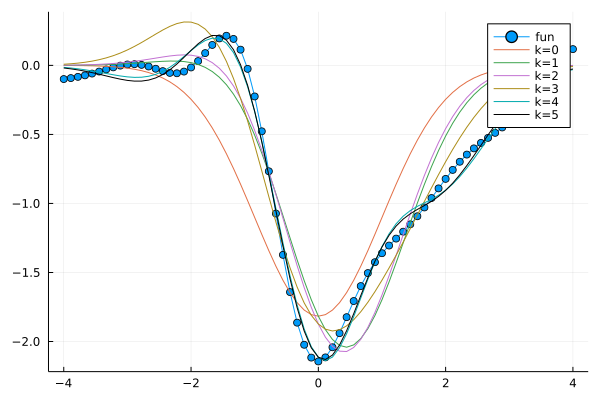

In [48]:
# V
f0 = base_fun(0, xx_ekg, true);
f1 = base_fun(1, xx_ekg, true);
f2 = base_fun(2, xx_ekg, true);
f3 = base_fun(3, xx_ekg, true);
f4 = base_fun(4, xx_ekg, true);
f5 = base_fun(5, xx_ekg, true);

c0 = dot(yy_ekgV, f0)
c1 = dot(yy_ekgV, f1)
c2 = dot(yy_ekgV, f2)
c3 = dot(yy_ekgV, f3)
c4 = dot(yy_ekgV, f4)
c5 = dot(yy_ekgV, f5)
c0, c1, c2, c3, c4, c5

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;
y_app_5 = c5*f5;

y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_012 + y_app_3 + y_app_4;
y_app_012345 = y_app_012 + y_app_3 + y_app_4 + y_app_5;

plot(xx_ekg, yy_ekgV, markershape=:circle, label="fun")
plot!(xx_ekg, y_app_0, label="k=0")
plot!(xx_ekg, y_app_01, label="k=1")
plot!(xx_ekg, y_app_012, label="k=2")
plot!(xx_ekg, y_app_0123, label="k=3")
plot!(xx_ekg, y_app_01234, label="k=4")
plot!(xx_ekg, y_app_012345, label="k=5", color ="black")

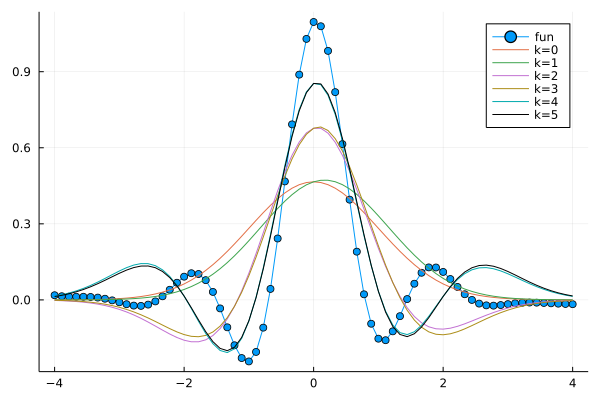

In [49]:
# N
c0 = dot(yy_ekgN, f0)
c1 = dot(yy_ekgN, f1)
c2 = dot(yy_ekgN, f2)
c3 = dot(yy_ekgN, f3)
c4 = dot(yy_ekgN, f4)
c5 = dot(yy_ekgN, f5)
c0, c1, c2, c3, c4, c5

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;
y_app_5 = c5*f5;

y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_012 + y_app_3 + y_app_4;
y_app_012345 = y_app_012 + y_app_3 + y_app_4 + y_app_5;

plot(xx_ekg, yy_ekgN, markershape=:circle, label="fun")
plot!(xx_ekg, y_app_0, label="k=0")
plot!(xx_ekg, y_app_01, label="k=1")
plot!(xx_ekg, y_app_012, label="k=2")
plot!(xx_ekg, y_app_0123, label="k=3")
plot!(xx_ekg, y_app_01234, label="k=4")
plot!(xx_ekg, y_app_012345, label="k=5", color ="black")

#### Zadanie 5  (1 pkt)

Przedstawić wykres błędu aproksymacji w zależności od stopnia wielomianu dla stopni od 0 do 10. Jakiego stopnia należy użyć gdybyśmy mieli robić coś dalej z rezultatem aproksymacji?

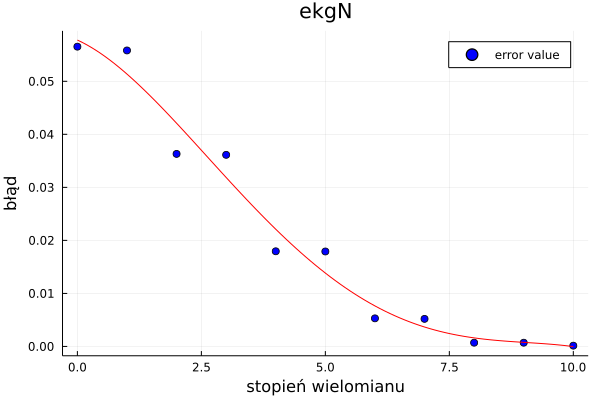

In [74]:
mse(y1, y2) = mean((y1-y2).^2)
f0 = base_fun(0, xx_ekg, true);
f1 = base_fun(1, xx_ekg, true);
f2 = base_fun(2, xx_ekg, true);
f3 = base_fun(3, xx_ekg, true);
f4 = base_fun(4, xx_ekg, true);
f5 = base_fun(5, xx_ekg, true);
f6 = base_fun(6, xx_ekg, true);
f7 = base_fun(7, xx_ekg, true);
f8 = base_fun(8, xx_ekg, true);
f9 = base_fun(9, xx_ekg, true);
f10 = base_fun(10, xx_ekg, true);

c0 = dot(yy_ekgN, f0)
c1 = dot(yy_ekgN, f1)
c2 = dot(yy_ekgN, f2)
c3 = dot(yy_ekgN, f3)
c4 = dot(yy_ekgN, f4)
c5 = dot(yy_ekgN, f5)
c6 = dot(yy_ekgN, f6)
c7 = dot(yy_ekgN, f7)
c8 = dot(yy_ekgN, f8)
c9 = dot(yy_ekgN, f9)
c10 = dot(yy_ekgN, f10)
c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;
y_app_5 = c5*f5;
y_app_6 = c6*f6;
y_app_7 = c7*f7;
y_app_8 = c8*f8;
y_app_9 = c9*f9;
y_app_10 = c10*f10;

y_app_0 = y_app_0
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_012 + y_app_3 + y_app_4;
y_app_012345 = y_app_012 + y_app_3 + y_app_4 + y_app_5;
y_app_0123456 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6;
y_app_01234567 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7;
y_app_012345678 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7 + y_app_8;
y_app_0123456789 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7 + y_app_8 + y_app_9;
y_app_01234567891 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7 + y_app_8 + y_app_9 + y_app_10;

k = 0:1:10
b = [mse(yy_ekgN,i) for i in[y_app_0,y_app_01,y_app_012,y_app_0123,y_app_01234,y_app_012345,y_app_0123456,y_app_01234567,y_app_012345678,y_app_0123456789,y_app_01234567891] ]
scatter(k,b, xlab="stopień wielomianu", ylab ="błąd", color="blue", label="error value", title="ekgN")

fit_f = fit(k, b, 4)
plot!(fit_f,  
    extrema(k)..., 
    label = "",
    color = "red"
)

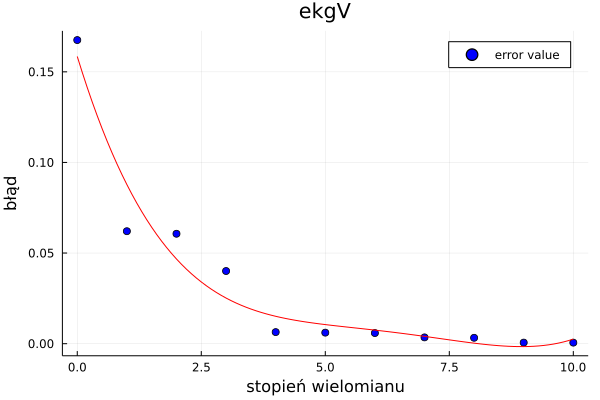

In [77]:
c0 = dot(yy_ekgV, f0)
c1 = dot(yy_ekgV, f1)
c2 = dot(yy_ekgV, f2)
c3 = dot(yy_ekgV, f3)
c4 = dot(yy_ekgV, f4)
c5 = dot(yy_ekgV, f5)
c6 = dot(yy_ekgV, f6)
c7 = dot(yy_ekgV, f7)
c8 = dot(yy_ekgV, f8)
c9 = dot(yy_ekgV, f9)
c10 = dot(yy_ekgV, f10)
c0, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10

y_app_0 = c0*f0;
y_app_1 = c1*f1;
y_app_2 = c2*f2;
y_app_3 = c3*f3;
y_app_4 = c4*f4;
y_app_5 = c5*f5;
y_app_6 = c6*f6;
y_app_7 = c7*f7;
y_app_8 = c8*f8;
y_app_9 = c9*f9;
y_app_10 = c10*f10;

y_app_0 = y_app_0
y_app_01 = y_app_0 + y_app_1;
y_app_012 = y_app_01 + y_app_2;
y_app_0123 = y_app_012 + y_app_3;
y_app_01234 = y_app_012 + y_app_3 + y_app_4;
y_app_012345 = y_app_012 + y_app_3 + y_app_4 + y_app_5;
y_app_0123456 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6;
y_app_01234567 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7;
y_app_012345678 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7 + y_app_8;
y_app_0123456789 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7 + y_app_8 + y_app_9;
y_app_01234567891 = y_app_012 + y_app_3 + y_app_4 + y_app_5 + y_app_6 + y_app_7 + y_app_8 + y_app_9 + y_app_10;

k = 0:1:10
b = [mse(yy_ekgV,i) for i in[y_app_0,y_app_01,y_app_012,y_app_0123,y_app_01234,y_app_012345,y_app_0123456,y_app_01234567,y_app_012345678,y_app_0123456789,y_app_01234567891] ]
scatter(k,b, xlab="stopień wielomianu", ylab ="błąd", color="blue", label="error value", title="ekgV")

fit_f = fit(k, b, 4)
plot!(fit_f,  
    extrema(k)..., 
    label = "",
    color = "red"
)

Patrząc na to, że błąd maleje zwiększając stopień wielomianu, należałoby wziąć największy.